In [1]:
#base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap

#Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

#Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


#Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import TargetEncoder

#for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#tunning hyperparamters model
import optuna

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True)

In [2]:
# Установка отображения всех строк и колонок
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Возвращаем настройки по умолчанию
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [3]:
traindata = pd.read_csv("/home/andrey/ds_bootcamp/Phase_1/ds-phase-1/group_project/ML_project/train.csv")
testdata = pd.read_csv("/home/andrey/ds_bootcamp/Phase_1/ds-phase-1/group_project/ML_project/test.csv")
#submission = pd.read_csv("/home/andrey/ds_bootcamp/Phase_1/ds-phase-1/group_project/submission.csv")

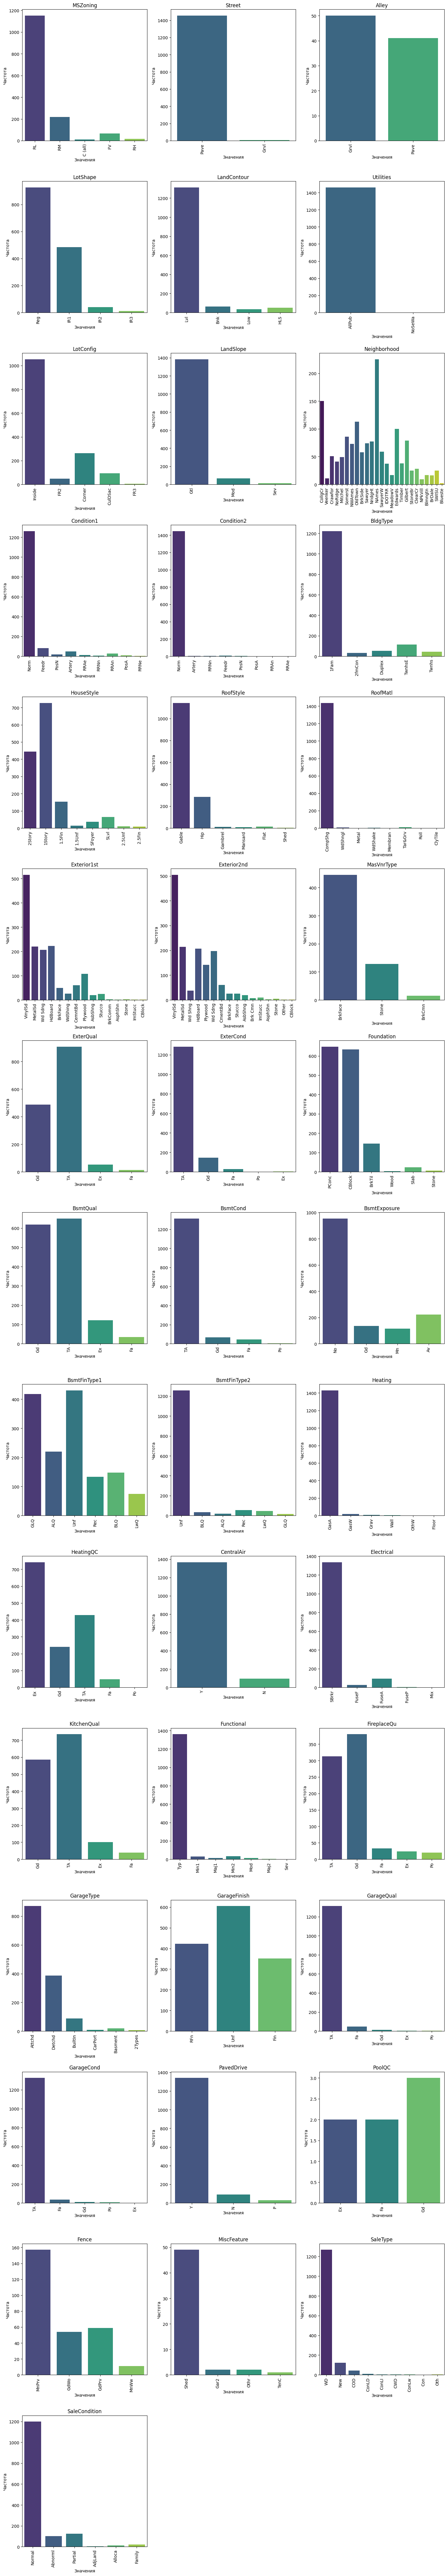

In [4]:
#Барплоты для всех категориальных признаков

# Выбор категориальных признаков
categorical_features = traindata.select_dtypes(include=['object']).columns

# Построение сабплота с барплотами
num_cols = len(categorical_features)
fig, axes = plt.subplots(nrows=(num_cols // 3) + (num_cols % 3 > 0), ncols=3, figsize=(15, num_cols * 2))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Построение барплотов
for i, feature in enumerate(categorical_features):
    sns.countplot(data=traindata, x=feature, ax=axes[i], palette='viridis')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Значения')
    axes[i].set_ylabel('Частота')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

# Удаление пустых осей
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

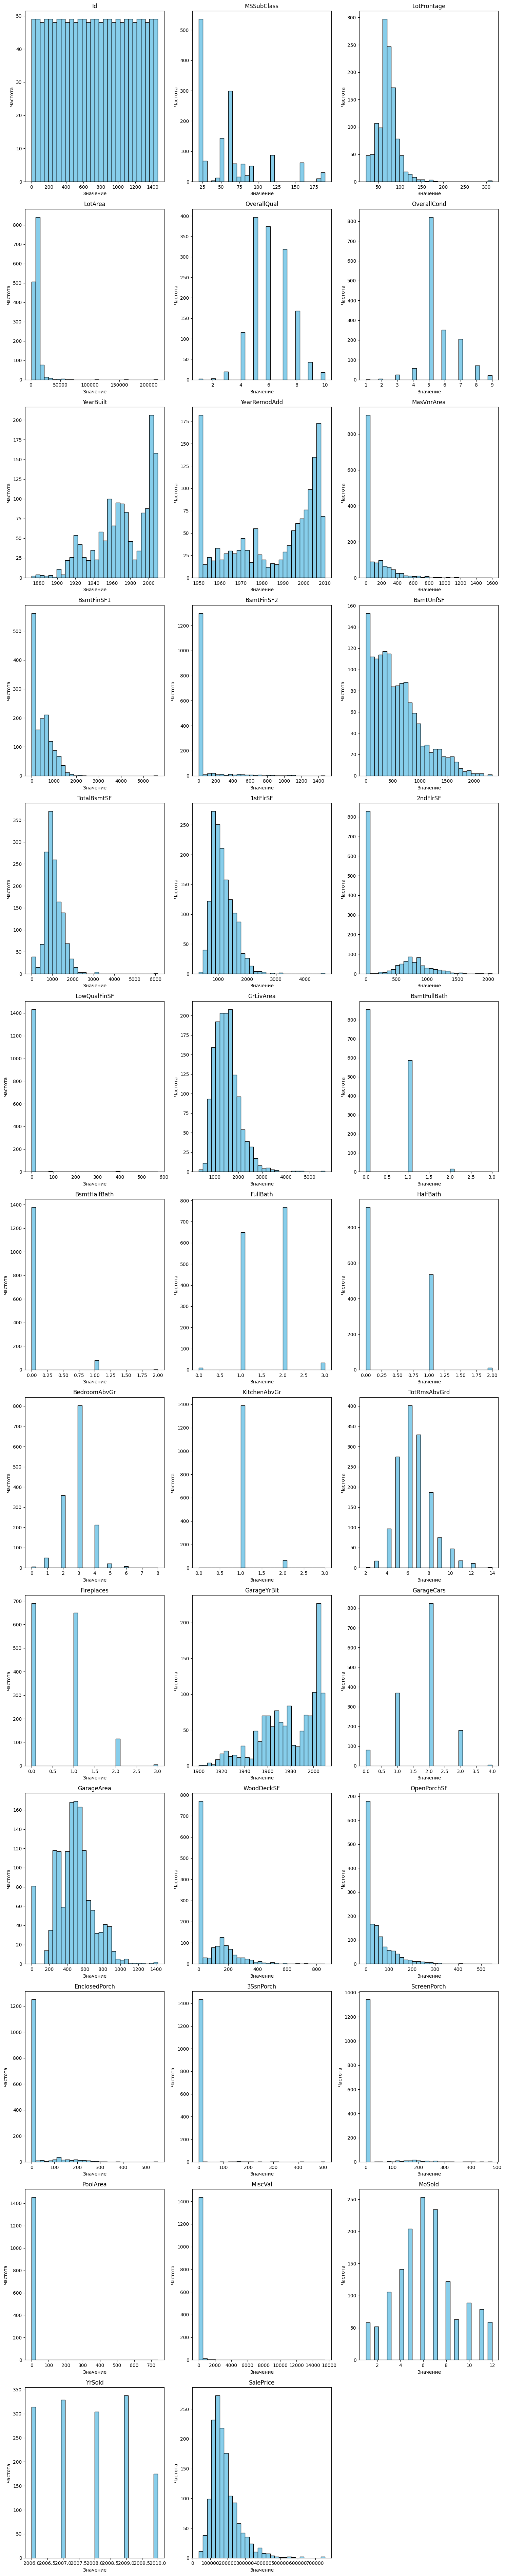

In [5]:
# Cабплот с гистограмами числовых признаков

numeric_features = traindata.select_dtypes(include=['int64', 'float64']).columns

# Построение сабплота с гистограммами
num_cols = len(numeric_features)
fig, axes = plt.subplots(nrows=(num_cols // 3) + (num_cols % 3 > 0), ncols=3, figsize=(15, num_cols * 2))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Построение гистограмм
for i, feature in enumerate(numeric_features):
    axes[i].hist(traindata[feature], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

# Удаление пустых осей
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Матрица корреляции')

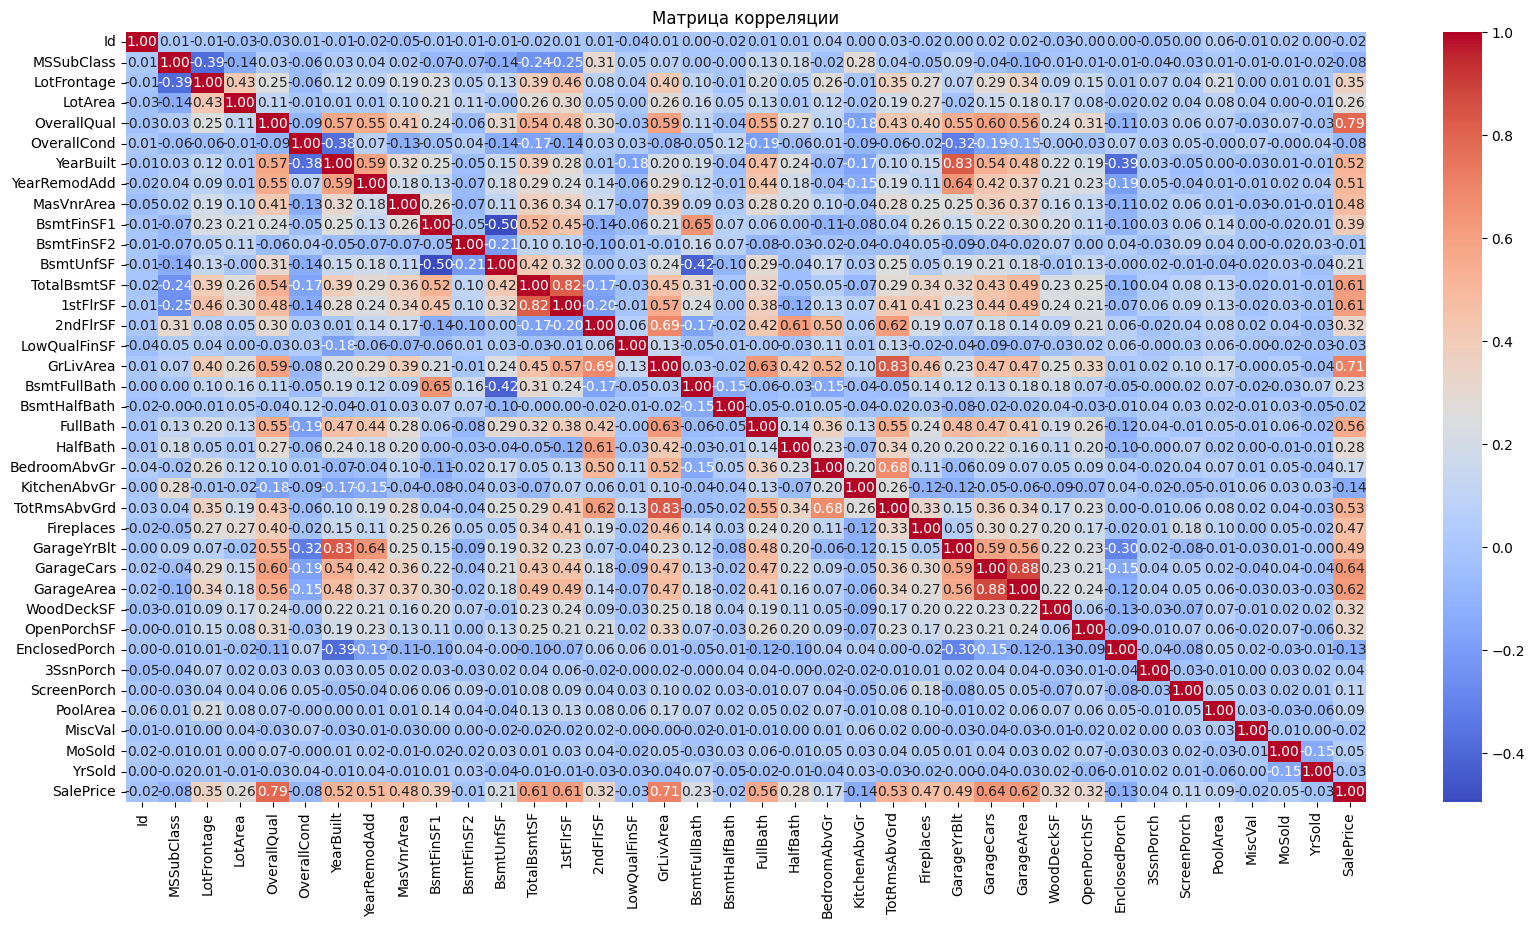

In [6]:
# Матрица корреляции

# Выбираем числовые столбцы
numeric_cols = traindata.select_dtypes(include=['number']).columns

# Строим матрицу корреляции
correlation_matrix = traindata[numeric_cols].corr()

# Создаем тепловую карту
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляции")

Text(0, 0.5, 'Количество домов')

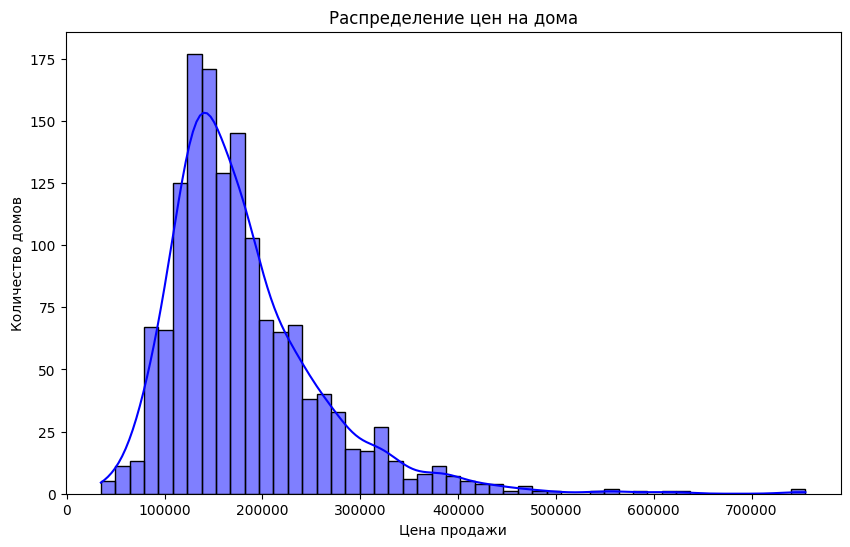

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(traindata['SalePrice'], kde=True, color='b')
plt.title('Распределение цен на дома')
plt.xlabel('Цена продажи')
plt.ylabel('Количество домов')

In [8]:
# Удаляем ненужные столбцы, такие как Id
if 'Id' in traindata.columns:
    traindata = traindata.drop(['Id'], axis=1)
if 'Id' in testdata.columns:
    testdata = testdata.drop(['Id'], axis=1)

In [9]:
#Разделим на features и target
X, y = traindata.drop('SalePrice', axis=1), np.log1p(traindata['SalePrice'])

In [10]:
#бъеденили train и test
#alldata = concat_df(X, testdata)
alldata = pd.concat([X, testdata], sort=True).reset_index(drop=True)

In [11]:
# drop_features = ['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath',
#                  'KitchenAbvGr', 'EnclosedPorch', 'MiscVal', 'YrSold']
# alldata_new = alldata.drop(drop_features, axis=1)

In [12]:
alldata.shape

(2919, 79)

In [13]:
# После предобработки разделяем обратно на тренировочный и тестовый наборы данных
X_train_full = alldata.iloc[:len(X), :]  # Возвращаем обратно тренировочные данные
X_test_full = alldata.iloc[len(X):, :]   # Возвращаем обратно тестовые данные

# Разделяем тренировочные данные на тренировочные и валидационные
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

In [14]:
# #no need
# NaN_count = pd.DataFrame(data={'NaN_count': alldata.isna().sum(), 'data_type':alldata.dtypes})
# NaN_columns = NaN_count[NaN_count['NaN_count'] > 0]
# NaN_columns

In [15]:
# Проверяем, что float_nan и object_nan_with_missing являются списками
float_nan = list(X_train.select_dtypes(include='float').columns)

# Выбираем колонки с типом object
object_nan = X_train.select_dtypes(include='object')
object_nan_with_missing = list(object_nan.loc[:, object_nan.isna().any()].columns)

#настройки
my_inputer = ColumnTransformer(
    transformers = [      
        ('float_nan', SimpleImputer(strategy='median'), float_nan),
        ('object_nan', SimpleImputer(strategy='constant', fill_value='Missing'), object_nan_with_missing)],
    verbose_feature_names_out = False,
    remainder = 'passthrough',
    force_int_remainder_cols=False
)

In [16]:
# Применение правил my_inputer, заполняя пропуски медианой или др. значениями
filled_data = my_inputer.fit_transform(X_train)
print(f"filled_data: {filled_data.shape}")

# Применение к X_valid данным
filled_valid_data = my_inputer.transform(X_valid)
print(f"filled_valid_data: {filled_valid_data.shape}")


filled_data: (1168, 79)
filled_valid_data: (292, 79)


In [17]:
# Определяем числовые и категориальные колонки для X_train
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns


# применяю скейлер для нормализации данных
# применяю энкодер для категориальных данных переводя их в 0 и 1
# Настраиваем ColumnTransformer для масштабирования и кодирования
scaler_and_encoder = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Применяем StandardScaler для числовых колонок
        ('cat', TargetEncoder(), categorical_columns)  # Применяем TargetEncoder для категориальных колонок
    ],
    remainder='passthrough',  # Остальные колонки пропускаем без изменений
    verbose_feature_names_out=False
)

In [18]:
# Применяем трансформер к обучающим данным
X_train_transformed = scaler_and_encoder.fit_transform(filled_data, y_train)
X_valid_transformed = scaler_and_encoder.transform(filled_valid_data)

In [19]:
# Проверяем размеры после трансформации
print(f"X_train_transformed: {X_train_transformed.shape}")
print(f"X_valid_transformed: {X_valid_transformed.shape}")

X_train_transformed: (1168, 79)
X_valid_transformed: (292, 79)


In [20]:
#объеденяю всё вместе в один pipeline
preprocessor = Pipeline([
    ('imputer', my_inputer),
    ('scaler_encoder', scaler_and_encoder),
])

preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('float_nan',
                                                  SimpleImputer(strategy='median'),
                                                  ['BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'GarageArea', 'GarageCars',
                                                   'GarageYrBlt', 'LotFrontage',
                                                   'MasVnrArea',
                                                   'TotalBsmtSF']),
                                                 ('object_nan',
                                                  SimpleImputer(fill_value...
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object'))],
                                   verbose_feature_names_out=False))])

# CatBoostRegressor

In [21]:
#Catboost
CatBoost_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(verbose=0, iterations=1512, learning_rate=0.128, depth=4))
    ]
)

In [22]:
#обучаю модель
CatBoost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('float_nan',
                                                                   SimpleImputer(strategy='median'),
                                                                   ['BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'BsmtUnfSF',
                                                                    'GarageArea',
                                                                    'GarageCars',
                                                                    'GarageYrBlt',
                                                                    'LotFrontage',
                                                                    'MasVnrArea',
                                                                    'TotalBsmtSF']),
                                                                  ('obje...
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object'))],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x78cdf45d5390>)])

In [23]:
#вывожу результат
# Предсказания для обучающего и валидационного набора
y_train_pred_CB = CatBoost_pipeline.predict(X_train)
y_valid_pred_CB = CatBoost_pipeline.predict(X_valid)

In [24]:
# # Вывод результатов с использованием метрики для регрессии
# print('CatBoost train MSE:', mean_squared_error(y_train, y_train_pred_CB))
# print('CatBoost valid MSE:', mean_squared_error(y_valid, y_valid_pred_CB))

# # Вывод R^2 для обучающего и валидационного набора
# print('CatBoost train R^2:', r2_score(y_train, y_train_pred_CB))
# print('CatBoost valid R^2:', r2_score(y_valid, y_valid_pred_CB))

In [25]:
# # Метрики для CatBoost
# cb_train_r2 = r2_score(y_train, y_train_pred_CB)
# cb_valid_r2 = r2_score(y_valid, y_valid_pred_CB)
# cb_train_mse = mean_squared_error(y_train, y_train_pred_CB)
# cb_valid_mse = mean_squared_error(y_valid, y_valid_pred_CB)

In [26]:
cb_train_r2 = r2_score(y_train, y_train_pred_CB)
cb_valid_r2 = r2_score(y_valid, y_valid_pred_CB)
cb_train_mse = mean_squared_error(y_train, y_train_pred_CB)
cb_valid_mse = mean_squared_error(y_valid, y_valid_pred_CB)
cb_train_rmse = root_mean_squared_error(y_train, y_train_pred_CB)
cb_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred_CB)
cb_train_mae = mean_absolute_error(y_train, y_train_pred_CB)
cb_valid_mae = mean_absolute_error(y_valid, y_valid_pred_CB)
cb_train_mape = mean_absolute_percentage_error(y_train, y_train_pred_CB)
cb_valid_mape = mean_absolute_percentage_error(y_valid, y_valid_pred_CB)
cb_train_rmsle = mean_squared_log_error(y_train, y_train_pred_CB)
cb_train_rmsle = mean_squared_log_error(y_valid, y_valid_pred_CB)

# RandomForestRegressor

In [27]:
#RandomForest
RandomForest_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=1000, random_state=42, verbose=0))
    ]
)
#обучаю модель
RandomForest_pipeline.fit(X_train, y_train)

#вывожу результат
# Предсказания для обучающего и валидационного набора
y_train_pred_RF = RandomForest_pipeline.predict(X_train)
y_valid_pred_RF = RandomForest_pipeline.predict(X_valid)

# # Вывод результатов с использованием метрики для регрессии
# print('RandomForestRegressor train MSE:', mean_squared_error(y_train, y_train_pred_RF))
# print('RandomForestRegressor valid MSE:', mean_squared_error(y_valid, y_valid_pred_RF))

# # Вывод R^2 для обучающего и валидационного набора
# print('RandomForestRegressor train R^2:', r2_score(y_train, y_train_pred_RF))
# print('RandomForestRegressor valid R^2:', r2_score(y_valid, y_valid_pred_RF))

In [28]:
# rf_train_mse = mean_squared_error(y_train, y_train_pred_RF)
# rf_valid_mse = mean_squared_error(y_valid, y_valid_pred_RF)
# rf_train_r2 = r2_score(y_train, y_train_pred_RF)
# rf_valid_r2 = r2_score(y_valid, y_valid_pred_RF)

In [29]:
rf_train_mse = mean_squared_error(y_train, y_train_pred_RF)
rf_valid_mse = mean_squared_error(y_valid, y_valid_pred_RF)
rf_train_r2 = r2_score(y_train, y_train_pred_RF)
rf_valid_r2 = r2_score(y_valid, y_valid_pred_RF)
rf_train_rmse = root_mean_squared_error(y_train, y_train_pred_RF)
rf_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred_RF)
rf_train_mae = mean_absolute_error(y_train, y_train_pred_RF)
rf_valid_mae = mean_absolute_error(y_valid, y_valid_pred_RF)
rf_train_mape = mean_absolute_percentage_error(y_train, y_train_pred_RF)
rf_valid_mape = mean_absolute_percentage_error(y_valid, y_valid_pred_RF)
rf_train_rmsle = mean_squared_log_error(y_train, y_train_pred_RF)
rf_train_rmsle = mean_squared_log_error(y_valid, y_valid_pred_RF)

In [30]:
model_results = {
    'CatBoostRegressor': [cb_train_r2, cb_valid_r2,
                          cb_train_mse, cb_valid_mse,
                          cb_train_rmse, cb_valid_rmse,
                          cb_train_mae, cb_valid_mae,
                          cb_train_mape, cb_valid_mape,
                          cb_train_rmsle, cb_train_rmsle
                         ],
    'RandomForestRegressor': [rf_train_r2, rf_valid_r2,
                              rf_train_mse, rf_valid_mse,
                              rf_train_rmse, rf_valid_rmse,
                              rf_train_mae, rf_valid_mae,
                              rf_train_mape, rf_valid_mape,
                              rf_train_rmsle, rf_train_rmsle
                             ]
}

results_df = pd.DataFrame.from_dict(model_results, orient='index',
                                    columns=['Train R^2', 'Valid R^2',
                                             'Train MSE', 'Valid MSE',
                                             'Train RMSE', 'Valid RMSE',
                                             'Train MAE', 'Valid MAE',
                                             'Train MAPE', 'Valid MAPE',
                                             'Train RMLSE', 'Valid RMLSE'
                                            ]).reset_index()

results_df.columns = ['Model', 'Train R^2', 'Valid R^2',
                      'Train MSE', 'Valid MSE',
                      'Train RMSE', 'Valid RMSE',
                      'Train MAE', 'Valid MAE',
                      'Train MAPE', 'Valid MAPE',
                      'Train RMLSE', 'Valid RMLSE'
                     ]

In [31]:
styled_table = results_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]}]
).set_properties(**{'text-align': 'left'}).format("{:.4f}", subset=['Train R^2', 'Valid R^2', 'Train MSE', 'Valid MSE',
                                                                    'Train RMSE', 'Valid RMSE', 'Train MAE', 'Valid MAE',
                                                                    'Train MAPE', 'Valid MAPE', 'Train RMLSE', 'Valid RMLSE'])

In [32]:
styled_table

,Model,Train R^2,Valid R^2,Train MSE,Valid MSE,Train RMSE,Valid RMSE,Train MAE,Valid MAE,Train MAPE,Valid MAPE,Train RMLSE,Valid RMLSE
0,CatBoostRegressor,0.9993,0.9039,0.0001,0.0179,0.0107,0.1339,0.0081,0.0880,0.0007,0.0074,0.0001,0.0001
1,RandomForestRegressor,0.9826,0.8887,0.0027,0.0208,0.0516,0.1441,0.0346,0.0939,0.0029,0.0079,0.0001,0.0001


In [33]:
# Формирование словаря с метриками для обеих моделей
model_results = {
    'CatBoostRegressor': [cb_train_r2, cb_valid_r2, cb_train_mse, cb_valid_mse],
    'RandomForestRegressor': [rf_train_r2, rf_valid_r2, rf_train_mse, rf_valid_mse]    
}

# Преобразуем словарь в DataFrame и задаем названия столбцов
results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Train R^2', 'Valid R^2', 'Train MSE', 'Valid MSE']).reset_index()
results_df.columns = ['Model', 'Train R^2', 'Valid R^2', 'Train MSE', 'Valid MSE']

# Стилизация таблицы
styled_table = results_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]}]
).set_properties(**{'text-align': 'left'}).format("{:.4f}", subset=['Train R^2', 'Valid R^2', 'Train MSE', 'Valid MSE'])

# Отображение стилизованной таблицы
styled_table

,Model,Train R^2,Valid R^2,Train MSE,Valid MSE
0,CatBoostRegressor,0.9993,0.9039,0.0001,0.0179
1,RandomForestRegressor,0.9826,0.8887,0.0027,0.0208


In [34]:
#обучаю модель
RandomForest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('float_nan',
                                                                   SimpleImputer(strategy='median'),
                                                                   ['BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'BsmtUnfSF',
                                                                    'GarageArea',
                                                                    'GarageCars',
                                                                    'GarageYrBlt',
                                                                    'LotFrontage',
                                                                    'MasVnrArea',
                                                                    'TotalBsmtSF']),
                                                                  ('obje...
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object'))],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestRegressor(n_estimators=1000, random_state=42))])

In [35]:
#вывожу результат
# Предсказания для обучающего и валидационного набора
y_train_pred_RF = RandomForest_pipeline.predict(X_train)
y_valid_pred_RF = RandomForest_pipeline.predict(X_valid)

In [36]:
# Вывод результатов с использованием метрики для регрессии
print('CatBoost train MSE:', mean_squared_error(y_train, y_train_pred_RF))
print('CatBoost valid MSE:', mean_squared_error(y_valid, y_valid_pred_RF))

# Вывод R^2 для обучающего и валидационного набора
print('CatBoost train R^2:', r2_score(y_train, y_train_pred_RF))
print('CatBoost valid R^2:', r2_score(y_valid, y_valid_pred_RF))

CatBoost train MSE: 0.0026577056479077294
CatBoost valid MSE: 0.020763755510844258
CatBoost train R^2: 0.9825658410701371
CatBoost valid R^2: 0.8887324070900682


In [37]:
# Обучаем модель на всех тренировочных данных
CatBoost_pipeline.fit(X_train_full, y)

# Делаем предсказания для тестового набора
test_predictions = CatBoost_pipeline.predict(X_test_full)

In [38]:
# Так как целевая переменная была логарифмирована (np.log1p), нам нужно выполнить обратное преобразование
test_predictions = np.expm1(test_predictions)

# Формируем DataFrame для создания submission.csv
submission = pd.DataFrame({
    'Id': testdata['Id'],  # Столбец 'Id' из исходного testdata
    'SalePrice': test_predictions  # Наши предсказанные цены
})

# Записываем результаты в файл
submission.to_csv('submission.csv', index=False)

print("Файл submission.csv успешно создан!")

KeyError: 'Id'

In [39]:
#графики
shap.initjs()
# Обучение модели CatBoostRegressor
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123, verbose=False)
model.fit(X_train_transformed, y_train)

In [40]:
traindata[numeric_cols].corr()['SalePrice'][:-1].sort_values(key=lambda x: abs(x), ascending=False)

KeyError: "['Id'] not in index"

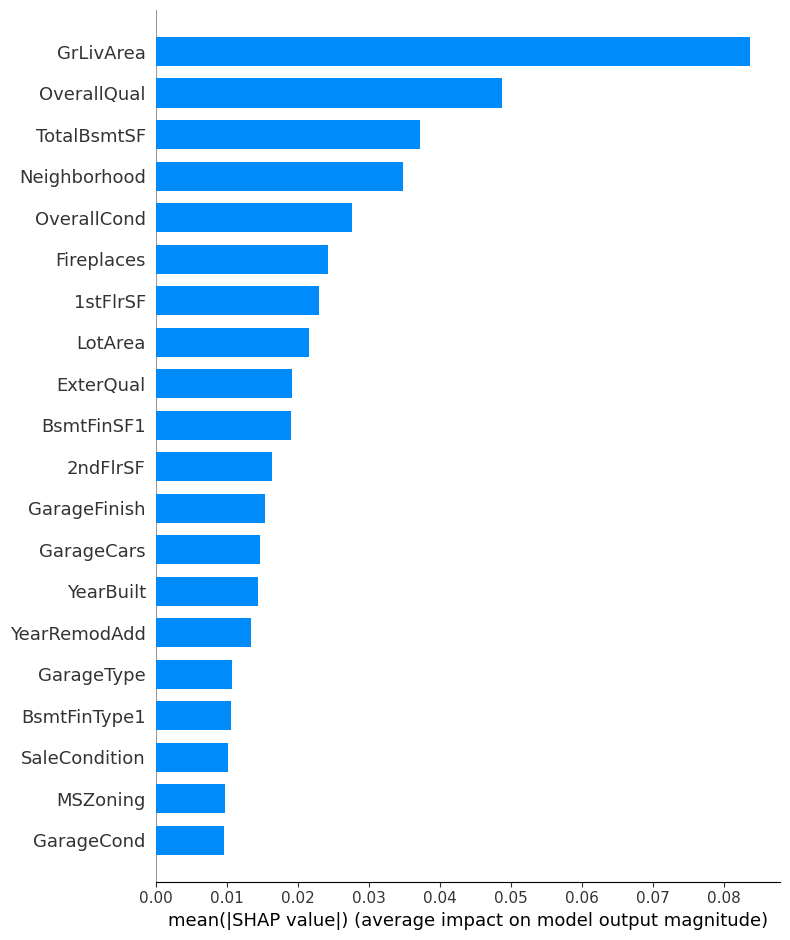

In [41]:
# Вычисляем SHAP значения для обученной модели CatBoost
explainer = shap.TreeExplainer(CatBoost_pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_train_transformed)

# Визуализация суммарной важности признаков
shap.summary_plot(shap_values, X_train_transformed, plot_type="bar")

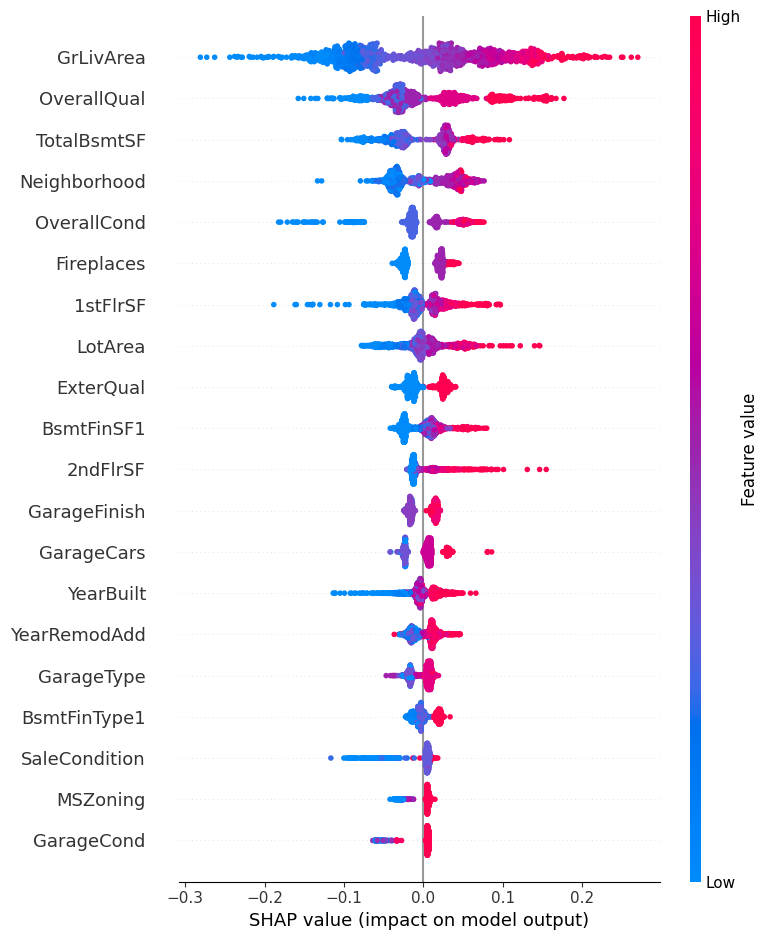

In [42]:
# Отображение вкладов каждого признака
shap.summary_plot(shap_values, X_train_transformed)

In [43]:
import joblib
joblib.dump(CatBoost_pipeline, 'cat_boost_pipline.pkl')

['cat_boost_pipline.pkl']